# Cart Pole Experimentation

Cart Pole is an environment provided by OpenAI gym. This is a really basic Reinforcement Learning (RL) environment - I recently saw it described as the "Hello World" of RL. The environment considers a pole on a cart, and the cart can either move left or right in order to keep the pole upright. If the pole falls beyond a certain angle, or the cart moves outside certain bounds, the episode terminates. 

The state is defined by the observation - this has cart position, cart velocity, pole angle, and pole
angular velocity in that order (these numbers are the output from env.reset()). env.step(action = 0 or 1) gives us observation, reward, done, info, in that order. The reward is +1 for every additional step, including the termination step. More information on the environment can be found here: https://www.gymlibrary.dev/environments/classic_control/cart_pole/

In this notebook, I want to build and train a RL agent to solve this environment successfully using a DDQN algorithm.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tqdm import tqdm
import pandas as pd
import numpy as np
import gymnasium as gym
from IPython import display
plt.rcParams['figure.dpi'] = 150

### Agent Class

In [8]:
class DQNAgent():
    """
    RL agent that utilizes a DQN algorithm to solve the Cart Pole environment.
    """
    
    def __init__(self, gamma=0.95, epsilon=0.9, epsilon_decay=0.995, epsilon_min=0.01, tau=0.99):
        """
        Initialize agent.
        
        Arguments:
            gamma (float): Future reward discounting factor
            epsilon (float): Starting value representing percentage of the time that the agent chooses a random action. E.g 0.75 = 75%
            epsilon_decay (float): Epsilon is multiplied by this factor after each episode.
            epsilon_min (float): Minimum value for epsilon.
            tau (float): Rate at which the target-q network is updated.
            
        Returns:
            None
        """
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min 
        self.tau = tau
        self.q_function = self.make_q_function()
        self.q_function.compile(loss='mse', optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)) 
        self.target_q = self.make_q_function()
        self.target_q.compile(loss='mse', optimizer=tf.keras.optimizers.legacy.Adam())
        self.target_q.set_weights(self.q_function.weights)
        self.max_memory = 10000
    
    
    def find_action(self, state):
        """
        Taking an action according to current policy of the agent. 
        
        Arguments:
            state (ndarray): cart position, cart velocity, pole angle, and pole angular velocity
        
        Returns:
            action (int): 0 or 1, corresponding to whether to push the cart left or right.
        """
        
        # If the random number is less than epsilon, we choose the action randomly
        if np.random.random() < self.epsilon:
            action = np.random.randint(0, 2)
            
        # Otherwise, choose the action that is the agent's current best guess for max future reward
        else:
            # Find action with best q-value
            # Find q-value estimates for each action using q-function
            q_vals = self.q_function.predict(state[np.newaxis, :], verbose=False)
            # Find best value by taking index of the largest argument
            action = np.argmax(q_vals)
    
        return action
    
    
    def take_step(self, env):
        """
        Take a step in the Cart Pole environment with the agent.
        
        Arguments:
            env: Cart Pole environment object
        
        Returns:
            old_state (ndarray): initial cart position, cart velocity, pole angle, and pole angular velocity
            action (int): 0 or 1, corresponding to whether the cart was pushed left or right
            reward (int): +1 if the episode has not yet terminated, 0 otherwise
            new_state (ndarray): new cart position, cart velocity, pole angle, and pole angular velocity
            done (bool): Whether or not episode has terminated
        """
        
        # Find action
        action = self.find_action(self.state)
        
        # Take step
        new_state, reward, done, info = env.step(action)[:4]
        old_state = self.state
        self.state = new_state
        
        return old_state, action, reward, new_state, done
    
    
    def make_q_function(self):
        """
        Create a q-function to estimate optimal total reward values for a given state-action pair.
        
        Arguments:
            None
        
        Returns:
            model: Untrained Keras sequential model. 
        """
        
        # Keras Sequential model
        # 2 outputs corresponding to left and right actions
        model = Sequential(
            [
                Dense(24, activation='relu', input_shape=(4,)),
                Dense(24, activation='relu'),
                Dense(2, activation='linear')
            ]
        )
        
        return model
        
    
    def train(self):
        """
        Use memory of experience to train agent using gradient descent.
        
        Arguments:
            None
            
        Returns:
            None
        """
            
        # Define target = current reward + gamma * target q of next state
        
        # Target q network predictions of future reward
        future_reward = np.max(self.target_q.predict(self.memory[:, -4:], verbose=False), axis=1)
        # Accounting for steps where episode terminated (no future reward)
        future_reward = np.where(self.memory[:, 6], 0, future_reward)
        
        target_vals = self.memory[:, 5] + self.gamma * future_reward
        
        # Creating targets
        q_vals = self.q_function.predict(self.memory[:, :4], verbose=False)
        
        current_actions = self.memory[:, 4]
        # Replacing q_function predictions with target_q targets
        col1 = ((q_vals[:, 0] * current_actions) + ((1 - current_actions) * target_vals)).reshape(q_vals.shape[0], 1)
        col2 = ((q_vals[:, 1] * (1 - current_actions)) + (current_actions * target_vals)).reshape(q_vals.shape[0], 1)
        final_target = np.concatenate((col1, col2), axis=1)
        
        # Train q-function with mse against target-q
        self.q_function.fit(self.memory[:, :4], final_target, shuffle=True, batch_size=64, verbose=False)
        
        # Using Polyak averaging to soft update target-q to be tau * target q weights + (1 - tau) * q weights
        new_weights = [self.tau * i + (1 - self.tau) * j for i, j in zip(self.target_q.weights, self.q_function.weights)]
        self.target_q.set_weights(new_weights) 
        
        
    def go(self, env, num_rounds=100):
        """
        Run the agent till termination num_rounds times.
        
        Arguments:
            env: Cart Pole environment object
            num_rounds (int): Number of times we want the agent to run until termination.
            
        Returns:
            None
        """
        
        # Initializing memory and episode length record
        self.memory = np.zeros((1, 11))
        length_lst = []
        
        # Each round is a complete runthrough of the environment until termination
        for i in tqdm(range(num_rounds)):
            
            # Tracking whether or not current iteration has terminated
            complete = False
            
            # Resetting to initial state
            self.state = env.reset()[0]
            
            # Variable to keep track of number of steps taken in each round
            length = 0
            
            while not complete:
                
                # Continue taking steps until termination
                old_state, action, reward, new_state, done = self.take_step(env)
                
                # Add data to agent memory
                if self.memory.any():
                    curr_data = np.append(np.append(old_state, (action, reward, done)), new_state).reshape(1, 11)
                    self.memory = np.concatenate((self.memory, curr_data), axis=0)
                else: 
                    self.memory = (np.append(np.append(old_state, (action, reward, done)), new_state)).reshape(1, 11)
                
                if done:
                    complete = True
                    
                length += 1
                
                if length > 550:
                    break

            # Sample memory if exceeding memory limit
            # Always keep initial 1000 steps' data
            if len(self.memory) > self.max_memory:
                idx = np.random.randint(1000, len(self.memory), size=self.max_memory - 1000) 
                self.memory = self.memory[np.append(np.arange(1000), idx), :]

            # Need > 64 for batch size
            if len(self.memory) > 64:
                self.train()
                
             # Decrease epsilon
            self.epsilon *= self.epsilon_decay
            self.epsilon = max(self.epsilon, self.epsilon_min)
            
            length_lst.append(length)
            
            if np.mean(length_lst[-10:]) >= 475:
                break
            
            if i % 10 == 0:
                print("Episode {}: \nlast 10 reward avg: {} \nepsilon: {} \nMemory size: {}".format(i, np.mean(length_lst[-10:]), self.epsilon, self.memory.shape[0]))
                               
        return length_lst


### Function for performance evaluation

In [9]:
def rolling_average(lengths, window):
    """
    Find the rolling average of the episode length.
    
    Arguments:
        lengths (lst): List of episode lengths
        window (int): Length of rolling average window of consideration
        
    Returns:
        avgs (lst):
    """
    avgs = []
    for i in range(len(lengths)):
        if i < window:
            avgs.append(0)
        else:
            avgs.append(np.mean(lengths[i - window: i]))
    return avgs

### Building and evaluating agent

In [4]:
agent = DQNAgent()

In [5]:
env = gym.make('CartPole-v1', render_mode='rgb_array')

In [6]:
lengths = agent.go(env, num_rounds=1000)

  0%|                                                                                            | 1/1000 [00:00<02:06,  7.92it/s]

Episode 0: 
last 10 reward avg: 18.0 
epsilon: 0.891 
Memory size: 18


  1%|█                                                                                          | 11/1000 [00:09<16:20,  1.01it/s]

Episode 10: 
last 10 reward avg: 16.8 
epsilon: 0.8058044288328449 
Memory size: 186


  2%|█▉                                                                                         | 21/1000 [00:24<20:24,  1.25s/it]

Episode 20: 
last 10 reward avg: 19.0 
epsilon: 0.7287550813991327 
Memory size: 376


  3%|██▊                                                                                        | 31/1000 [00:50<52:06,  3.23s/it]

Episode 30: 
last 10 reward avg: 30.4 
epsilon: 0.6590730326889578 
Memory size: 680


  4%|███▋                                                                                     | 41/1000 [01:39<1:31:29,  5.72s/it]

Episode 40: 
last 10 reward avg: 49.4 
epsilon: 0.5960538368855853 
Memory size: 1174


  5%|████▌                                                                                    | 51/1000 [02:36<1:02:20,  3.94s/it]

Episode 50: 
last 10 reward avg: 51.3 
epsilon: 0.5390604058195451 
Memory size: 1687


  6%|█████▍                                                                                   | 61/1000 [03:32<2:17:21,  8.78s/it]

Episode 60: 
last 10 reward avg: 43.7 
epsilon: 0.48751656837016827 
Memory size: 2124


  7%|██████▍                                                                                    | 71/1000 [04:37<49:40,  3.21s/it]

Episode 70: 
last 10 reward avg: 45.9 
epsilon: 0.4409012457037845 
Memory size: 2583


  8%|███████▏                                                                                 | 81/1000 [06:03<2:48:41, 11.01s/it]

Episode 80: 
last 10 reward avg: 53.7 
epsilon: 0.39874318346355536 
Memory size: 3120


  9%|████████                                                                                 | 91/1000 [08:00<2:47:10, 11.03s/it]

Episode 90: 
last 10 reward avg: 66.6 
epsilon: 0.3606161876563865 
Memory size: 3786


 10%|████████▉                                                                               | 101/1000 [09:53<2:26:37,  9.79s/it]

Episode 100: 
last 10 reward avg: 58.5 
epsilon: 0.3261348160744472 
Memory size: 4371


 11%|█████████▊                                                                              | 111/1000 [11:46<3:19:02, 13.43s/it]

Episode 110: 
last 10 reward avg: 53.7 
epsilon: 0.2949504816940234 
Memory size: 4908


 12%|██████████▋                                                                             | 121/1000 [13:52<3:40:09, 15.03s/it]

Episode 120: 
last 10 reward avg: 56.4 
epsilon: 0.26674792865928726 
Memory size: 5472


 13%|███████████▌                                                                            | 131/1000 [16:59<5:58:17, 24.74s/it]

Episode 130: 
last 10 reward avg: 76.3 
epsilon: 0.24124204522518672 
Memory size: 6235


 14%|████████████▍                                                                           | 141/1000 [18:44<1:50:29,  7.72s/it]

Episode 140: 
last 10 reward avg: 40.0 
epsilon: 0.2181749814401222 
Memory size: 6635


 15%|█████████████▎                                                                          | 151/1000 [21:24<5:40:16, 24.05s/it]

Episode 150: 
last 10 reward avg: 57.3 
epsilon: 0.1973135424298251 
Memory size: 7208


 16%|██████████████▏                                                                         | 161/1000 [26:05<6:22:01, 27.32s/it]

Episode 160: 
last 10 reward avg: 93.9 
epsilon: 0.178446830930023 
Memory size: 8147


 17%|███████████████                                                                         | 171/1000 [28:47<2:48:09, 12.17s/it]

Episode 170: 
last 10 reward avg: 50.1 
epsilon: 0.1613841152352395 
Memory size: 8648


 18%|███████████████▉                                                                        | 181/1000 [34:13<7:45:56, 34.14s/it]

Episode 180: 
last 10 reward avg: 95.9 
epsilon: 0.14595290100990588 
Memory size: 9607


 19%|████████████████▊                                                                       | 191/1000 [39:37<6:05:31, 27.11s/it]

Episode 190: 
last 10 reward avg: 88.4 
epsilon: 0.13199718746889333 
Memory size: 10000


 20%|█████████████████▋                                                                      | 201/1000 [41:55<3:05:47, 13.95s/it]

Episode 200: 
last 10 reward avg: 38.1 
epsilon: 0.1193758902984439 
Memory size: 10000


 21%|██████████████████▌                                                                     | 211/1000 [45:23<5:19:18, 24.28s/it]

Episode 210: 
last 10 reward avg: 56.5 
epsilon: 0.1079614153741301 
Memory size: 10000


 22%|███████████████████▍                                                                    | 221/1000 [48:44<3:57:17, 18.28s/it]

Episode 220: 
last 10 reward avg: 54.6 
epsilon: 0.09763836885694321 
Memory size: 10000


 23%|████████████████████▎                                                                   | 231/1000 [53:58<8:13:32, 38.51s/it]

Episode 230: 
last 10 reward avg: 84.3 
epsilon: 0.08830239062731732 
Memory size: 10000


 24%|████████████████████▏                                                               | 241/1000 [1:10:52<25:17:24, 119.95s/it]

Episode 240: 
last 10 reward avg: 137.9 
epsilon: 0.07985909926377122 
Memory size: 10000


 25%|█████████████████████▌                                                                | 251/1000 [1:15:26<7:34:01, 36.37s/it]

Episode 250: 
last 10 reward avg: 63.0 
epsilon: 0.07222313790050347 
Memory size: 10000


 26%|██████████████████████▍                                                               | 261/1000 [1:22:56<9:26:08, 45.96s/it]

Episode 260: 
last 10 reward avg: 100.9 
epsilon: 0.06531731131810435 
Memory size: 10000


 27%|███████████████████████▎                                                              | 271/1000 [1:29:24<7:58:48, 39.41s/it]

Episode 270: 
last 10 reward avg: 98.9 
epsilon: 0.05907180554386329 
Memory size: 10000


 28%|████████████████████████▏                                                             | 281/1000 [1:34:26<7:17:38, 36.52s/it]

Episode 280: 
last 10 reward avg: 82.0 
epsilon: 0.05342348207227568 
Memory size: 10000


 29%|█████████████████████████                                                             | 291/1000 [1:41:10<8:32:18, 43.35s/it]

Episode 290: 
last 10 reward avg: 108.7 
epsilon: 0.04831523957072034 
Memory size: 10000


 30%|█████████████████████████▉                                                            | 301/1000 [1:47:29<7:54:33, 40.73s/it]

Episode 300: 
last 10 reward avg: 101.4 
epsilon: 0.04369543661751556 
Memory size: 10000


 31%|██████████████████████████▋                                                           | 311/1000 [1:53:15<4:55:36, 25.74s/it]

Episode 310: 
last 10 reward avg: 92.8 
epsilon: 0.04 
Memory size: 10000


 32%|███████████████████████████▌                                                          | 321/1000 [1:57:39<6:04:50, 32.24s/it]

Episode 320: 
last 10 reward avg: 70.3 
epsilon: 0.04 
Memory size: 10000


 33%|████████████████████████████▍                                                         | 331/1000 [2:01:44<4:07:00, 22.15s/it]

Episode 330: 
last 10 reward avg: 55.3 
epsilon: 0.04 
Memory size: 10000


 34%|█████████████████████████████▎                                                        | 341/1000 [2:08:40<9:34:58, 52.35s/it]

Episode 340: 
last 10 reward avg: 109.2 
epsilon: 0.04 
Memory size: 10000


 35%|██████████████████████████████▏                                                       | 351/1000 [2:15:49<7:24:13, 41.07s/it]

Episode 350: 
last 10 reward avg: 116.3 
epsilon: 0.04 
Memory size: 10000


 36%|███████████████████████████████                                                       | 361/1000 [2:24:05<7:22:01, 41.50s/it]

Episode 360: 
last 10 reward avg: 134.9 
epsilon: 0.04 
Memory size: 10000


 37%|███████████████████████████████▉                                                      | 371/1000 [2:32:45<9:43:21, 55.65s/it]

Episode 370: 
last 10 reward avg: 111.6 
epsilon: 0.04 
Memory size: 10000


 38%|████████████████████████████████▊                                                     | 381/1000 [2:37:57<4:48:16, 27.94s/it]

Episode 380: 
last 10 reward avg: 81.6 
epsilon: 0.04 
Memory size: 10000


 39%|█████████████████████████████████▋                                                    | 391/1000 [2:42:22<5:20:54, 31.62s/it]

Episode 390: 
last 10 reward avg: 71.3 
epsilon: 0.04 
Memory size: 10000


 40%|██████████████████████████████████                                                   | 401/1000 [2:50:37<10:35:52, 63.69s/it]

Episode 400: 
last 10 reward avg: 133.5 
epsilon: 0.04 
Memory size: 10000


 41%|███████████████████████████████████▎                                                  | 411/1000 [2:57:27<5:46:48, 35.33s/it]

Episode 410: 
last 10 reward avg: 103.0 
epsilon: 0.04 
Memory size: 10000


 42%|████████████████████████████████████▏                                                 | 421/1000 [3:05:31<8:31:45, 53.03s/it]

Episode 420: 
last 10 reward avg: 115.3 
epsilon: 0.04 
Memory size: 10000


 43%|█████████████████████████████████████                                                 | 431/1000 [3:11:04<3:34:16, 22.60s/it]

Episode 430: 
last 10 reward avg: 81.6 
epsilon: 0.04 
Memory size: 10000


 44%|█████████████████████████████████████▉                                                | 441/1000 [3:18:23<7:11:15, 46.29s/it]

Episode 440: 
last 10 reward avg: 111.6 
epsilon: 0.04 
Memory size: 10000


 45%|██████████████████████████████████████▊                                               | 451/1000 [3:22:15<4:10:14, 27.35s/it]

Episode 450: 
last 10 reward avg: 61.4 
epsilon: 0.04 
Memory size: 10000


 46%|███████████████████████████████████████▋                                              | 461/1000 [3:27:49<4:19:00, 28.83s/it]

Episode 460: 
last 10 reward avg: 88.3 
epsilon: 0.04 
Memory size: 10000


 47%|████████████████████████████████████████▌                                             | 471/1000 [3:33:51<5:15:27, 35.78s/it]

Episode 470: 
last 10 reward avg: 93.9 
epsilon: 0.04 
Memory size: 10000


 48%|█████████████████████████████████████████▎                                            | 481/1000 [3:40:33<5:37:47, 39.05s/it]

Episode 480: 
last 10 reward avg: 104.2 
epsilon: 0.04 
Memory size: 10000


 49%|██████████████████████████████████████████▏                                           | 491/1000 [3:43:32<1:32:40, 10.92s/it]

Episode 490: 
last 10 reward avg: 47.8 
epsilon: 0.04 
Memory size: 10000


 50%|███████████████████████████████████████████                                           | 501/1000 [3:45:21<1:24:18, 10.14s/it]

Episode 500: 
last 10 reward avg: 29.1 
epsilon: 0.04 
Memory size: 10000


 51%|███████████████████████████████████████████▍                                         | 511/1000 [3:54:20<12:09:37, 89.52s/it]

Episode 510: 
last 10 reward avg: 143.0 
epsilon: 0.04 
Memory size: 10000


 52%|████████████████████████████████████████████▊                                         | 521/1000 [4:03:55<5:43:28, 43.02s/it]

Episode 520: 
last 10 reward avg: 152.0 
epsilon: 0.04 
Memory size: 10000


 53%|█████████████████████████████████████████████▋                                        | 531/1000 [4:11:46<4:02:41, 31.05s/it]

Episode 530: 
last 10 reward avg: 124.4 
epsilon: 0.04 
Memory size: 10000


 54%|██████████████████████████████████████████████▌                                       | 541/1000 [4:16:30<3:09:48, 24.81s/it]

Episode 540: 
last 10 reward avg: 75.4 
epsilon: 0.04 
Memory size: 10000


 55%|███████████████████████████████████████████████▍                                      | 551/1000 [4:23:08<4:47:38, 38.44s/it]

Episode 550: 
last 10 reward avg: 104.2 
epsilon: 0.04 
Memory size: 10000


 56%|████████████████████████████████████████████████▏                                     | 561/1000 [4:28:36<2:49:42, 23.20s/it]

Episode 560: 
last 10 reward avg: 87.4 
epsilon: 0.04 
Memory size: 10000


 57%|█████████████████████████████████████████████████                                     | 571/1000 [4:35:05<3:23:36, 28.48s/it]

Episode 570: 
last 10 reward avg: 103.2 
epsilon: 0.04 
Memory size: 10000


 58%|█████████████████████████████████████████████████▉                                    | 581/1000 [4:40:33<4:22:13, 37.55s/it]

Episode 580: 
last 10 reward avg: 86.6 
epsilon: 0.04 
Memory size: 10000


 59%|██████████████████████████████████████████████████▊                                   | 591/1000 [4:46:13<5:24:15, 47.57s/it]

Episode 590: 
last 10 reward avg: 90.4 
epsilon: 0.04 
Memory size: 10000


 60%|███████████████████████████████████████████████████▋                                  | 601/1000 [4:49:25<1:55:08, 17.32s/it]

Episode 600: 
last 10 reward avg: 52.2 
epsilon: 0.04 
Memory size: 10000


 61%|████████████████████████████████████████████████████▌                                 | 611/1000 [4:54:13<3:13:48, 29.89s/it]

Episode 610: 
last 10 reward avg: 73.9 
epsilon: 0.04 
Memory size: 10000


 62%|█████████████████████████████████████████████████████▍                                | 621/1000 [4:56:36<1:17:27, 12.26s/it]

Episode 620: 
last 10 reward avg: 37.1 
epsilon: 0.04 
Memory size: 10000


 63%|██████████████████████████████████████████████████████▎                               | 631/1000 [4:59:06<1:20:30, 13.09s/it]

Episode 630: 
last 10 reward avg: 35.6 
epsilon: 0.04 
Memory size: 10000


 64%|███████████████████████████████████████████████████████▏                              | 641/1000 [5:03:10<2:06:05, 21.07s/it]

Episode 640: 
last 10 reward avg: 59.4 
epsilon: 0.04 
Memory size: 10000


 65%|███████████████████████████████████████████████████████▉                              | 651/1000 [5:06:36<2:15:40, 23.33s/it]

Episode 650: 
last 10 reward avg: 49.9 
epsilon: 0.04 
Memory size: 10000


 66%|████████████████████████████████████████████████████████▊                             | 661/1000 [5:11:13<2:03:53, 21.93s/it]

Episode 660: 
last 10 reward avg: 68.5 
epsilon: 0.04 
Memory size: 10000


 67%|█████████████████████████████████████████████████████████▋                            | 671/1000 [5:16:17<1:41:03, 18.43s/it]

Episode 670: 
last 10 reward avg: 78.7 
epsilon: 0.04 
Memory size: 10000


 68%|██████████████████████████████████████████████████████████▌                           | 681/1000 [5:20:59<3:21:36, 37.92s/it]

Episode 680: 
last 10 reward avg: 71.6 
epsilon: 0.04 
Memory size: 10000


 69%|███████████████████████████████████████████████████████████▍                          | 691/1000 [5:23:45<1:26:35, 16.81s/it]

Episode 690: 
last 10 reward avg: 41.5 
epsilon: 0.04 
Memory size: 10000


 70%|████████████████████████████████████████████████████████████▎                         | 701/1000 [5:27:50<1:35:09, 19.09s/it]

Episode 700: 
last 10 reward avg: 64.7 
epsilon: 0.04 
Memory size: 10000


 71%|█████████████████████████████████████████████████████████████▏                        | 711/1000 [5:31:10<2:33:39, 31.90s/it]

Episode 710: 
last 10 reward avg: 50.4 
epsilon: 0.04 
Memory size: 10000


 72%|██████████████████████████████████████████████████████████████                        | 721/1000 [5:33:54<1:07:49, 14.59s/it]

Episode 720: 
last 10 reward avg: 43.4 
epsilon: 0.04 
Memory size: 10000


 73%|██████████████████████████████████████████████████████████████▊                       | 731/1000 [5:39:17<2:16:15, 30.39s/it]

Episode 730: 
last 10 reward avg: 84.5 
epsilon: 0.04 
Memory size: 10000


 74%|███████████████████████████████████████████████████████████████▋                      | 741/1000 [5:42:41<1:14:40, 17.30s/it]

Episode 740: 
last 10 reward avg: 53.9 
epsilon: 0.04 
Memory size: 10000


 75%|██████████████████████████████████████████████████████████████████                      | 751/1000 [5:45:09<59:29, 14.34s/it]

Episode 750: 
last 10 reward avg: 38.9 
epsilon: 0.04 
Memory size: 10000


 76%|█████████████████████████████████████████████████████████████████▍                    | 761/1000 [5:49:03<1:31:32, 22.98s/it]

Episode 760: 
last 10 reward avg: 62.9 
epsilon: 0.04 
Memory size: 10000


 77%|██████████████████████████████████████████████████████████████████▎                   | 771/1000 [5:54:09<2:10:34, 34.21s/it]

Episode 770: 
last 10 reward avg: 82.0 
epsilon: 0.04 
Memory size: 10000


 78%|███████████████████████████████████████████████████████████████████▏                  | 781/1000 [5:58:19<2:12:12, 36.22s/it]

Episode 780: 
last 10 reward avg: 61.8 
epsilon: 0.04 
Memory size: 10000


 79%|████████████████████████████████████████████████████████████████████                  | 791/1000 [6:04:00<1:53:23, 32.55s/it]

Episode 790: 
last 10 reward avg: 82.9 
epsilon: 0.04 
Memory size: 10000


 80%|████████████████████████████████████████████████████████████████████▉                 | 801/1000 [6:10:34<2:03:52, 37.35s/it]

Episode 800: 
last 10 reward avg: 95.3 
epsilon: 0.04 
Memory size: 10000


 81%|█████████████████████████████████████████████████████████████████████▋                | 811/1000 [6:15:56<2:05:47, 39.93s/it]

Episode 810: 
last 10 reward avg: 82.7 
epsilon: 0.04 
Memory size: 10000


 82%|████████████████████████████████████████████████████████████████████████▏               | 821/1000 [6:19:34<58:22, 19.57s/it]

Episode 820: 
last 10 reward avg: 58.3 
epsilon: 0.04 
Memory size: 10000


 83%|█████████████████████████████████████████████████████████████████████████▏              | 831/1000 [6:21:49<47:57, 17.03s/it]

Episode 830: 
last 10 reward avg: 35.5 
epsilon: 0.04 
Memory size: 10000


 84%|████████████████████████████████████████████████████████████████████████▎             | 841/1000 [6:26:17<1:17:05, 29.09s/it]

Episode 840: 
last 10 reward avg: 71.7 
epsilon: 0.04 
Memory size: 10000


 85%|██████████████████████████████████████████████████████████████████████████▉             | 851/1000 [6:29:02<41:10, 16.58s/it]

Episode 850: 
last 10 reward avg: 43.6 
epsilon: 0.04 
Memory size: 10000


 86%|███████████████████████████████████████████████████████████████████████████▊            | 861/1000 [6:32:52<57:35, 24.86s/it]

Episode 860: 
last 10 reward avg: 61.2 
epsilon: 0.04 
Memory size: 10000


 87%|████████████████████████████████████████████████████████████████████████████▋           | 871/1000 [6:36:30<46:40, 21.71s/it]

Episode 870: 
last 10 reward avg: 57.9 
epsilon: 0.04 
Memory size: 10000


 88%|█████████████████████████████████████████████████████████████████████████████▌          | 881/1000 [6:40:30<41:55, 21.14s/it]

Episode 880: 
last 10 reward avg: 63.7 
epsilon: 0.04 
Memory size: 10000


 89%|██████████████████████████████████████████████████████████████████████████████▍         | 891/1000 [6:43:22<27:18, 15.03s/it]

Episode 890: 
last 10 reward avg: 45.9 
epsilon: 0.04 
Memory size: 10000


 90%|█████████████████████████████████████████████████████████████████████████████▍        | 901/1000 [6:49:06<1:48:46, 65.92s/it]

Episode 900: 
last 10 reward avg: 90.3 
epsilon: 0.04 
Memory size: 10000


 91%|████████████████████████████████████████████████████████████████████████████████▏       | 911/1000 [6:51:56<26:23, 17.79s/it]

Episode 910: 
last 10 reward avg: 45.3 
epsilon: 0.04 
Memory size: 10000


 92%|█████████████████████████████████████████████████████████████████████████████████       | 921/1000 [6:56:04<36:18, 27.57s/it]

Episode 920: 
last 10 reward avg: 65.7 
epsilon: 0.04 
Memory size: 10000


 93%|█████████████████████████████████████████████████████████████████████████████████▉      | 931/1000 [7:00:44<34:40, 30.15s/it]

Episode 930: 
last 10 reward avg: 68.9 
epsilon: 0.04 
Memory size: 10000


 94%|██████████████████████████████████████████████████████████████████████████████████▊     | 941/1000 [7:05:15<22:10, 22.56s/it]

Episode 940: 
last 10 reward avg: 67.4 
epsilon: 0.04 
Memory size: 10000


 95%|███████████████████████████████████████████████████████████████████████████████████▋    | 951/1000 [7:08:38<13:54, 17.03s/it]

Episode 950: 
last 10 reward avg: 49.4 
epsilon: 0.04 
Memory size: 10000


 96%|████████████████████████████████████████████████████████████████████████████████████▌   | 961/1000 [7:12:06<10:10, 15.65s/it]

Episode 960: 
last 10 reward avg: 52.9 
epsilon: 0.04 
Memory size: 10000


 97%|█████████████████████████████████████████████████████████████████████████████████████▍  | 971/1000 [7:15:30<07:28, 15.48s/it]

Episode 970: 
last 10 reward avg: 53.5 
epsilon: 0.04 
Memory size: 10000


 98%|██████████████████████████████████████████████████████████████████████████████████████▎ | 981/1000 [7:18:08<04:23, 13.87s/it]

Episode 980: 
last 10 reward avg: 41.6 
epsilon: 0.04 
Memory size: 10000


 99%|███████████████████████████████████████████████████████████████████████████████████████▏| 991/1000 [7:21:48<03:19, 22.17s/it]

Episode 990: 
last 10 reward avg: 56.5 
epsilon: 0.04 
Memory size: 10000


100%|███████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [7:25:11<00:00, 26.71s/it]


Text(0, 0.5, 'Episode length')

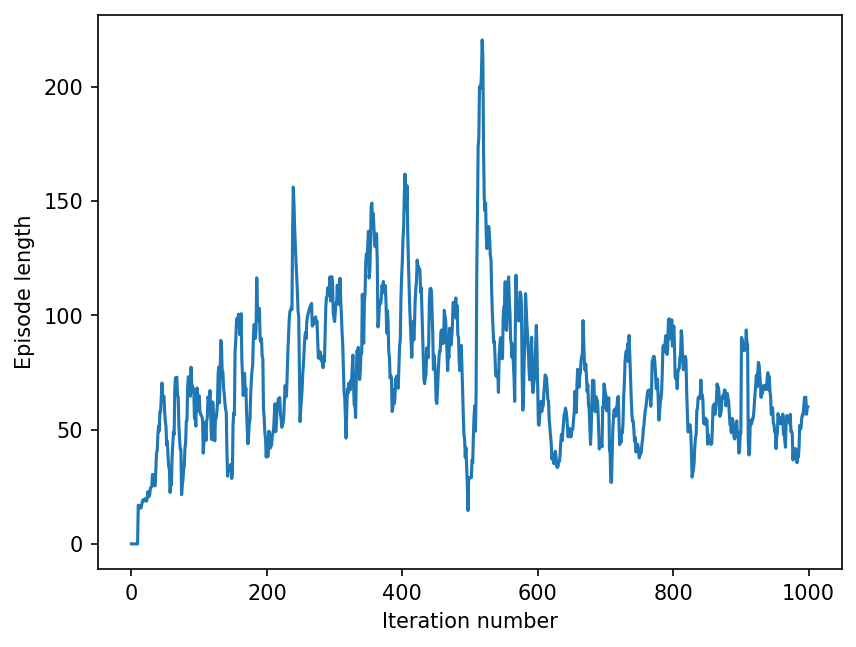

In [7]:
iters = np.arange(1000)
plt.plot(iters, rolling_average(lengths, 10))
plt.xlabel("Iteration number")
plt.ylabel("Episode length")

In [ ]:
done = False

env = gym.make('CartPole-v1', render_mode='rgb_array')
agent.state = env.reset()[0]
agent_lengths = []

for i in tqdm(range(100)):
    
    env.reset()
    
    ep_length = 0
    
    done = False
    
    while not done:
        _, _, _, _, done = agent.take_step(env)
        ep_length += 1
    
    agent_lengths.append(ep_length)

In [ ]:
done = False

env = gym.make('CartPole-v1', render_mode='rgb_array')
random_lengths = []

for i in tqdm(range(100)):
    
    env.reset()
    
    done = False
    
    ep_length = 0
    
    while not done:
        action = np.random.randint(0, 2)
        _, _, done, _, _ = env.step(action)
        ep_length += 1
    
    random_lengths.append(ep_length)

In [ ]:
np.mean(agent_lengths)

In [ ]:
np.mean(random_lengths)

In [ ]:
plt.plot(np.arange(100), rolling_average(agent_lengths, 10), label='Agent')
plt.plot(np.arange(100), rolling_average(random_lengths, 10 ), label='Random')
plt.legend()

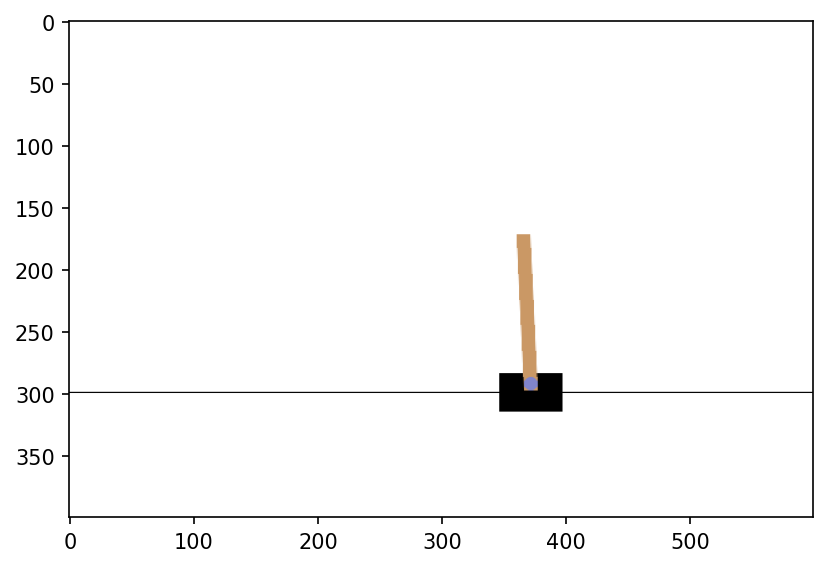

In [16]:
env = gym.make('CartPole-v1', render_mode='rgb_array')
agent.state = env.reset()[0]

for i in range(50):
    plt.imshow(env.render())
    display.display(plt.gcf())    
    display.clear_output(wait=True)
#     env.step(env.action_space.sample()) # take a random action
    env.step(agent.find_action(agent.state))
    agent.state = np.array(env.state)
    
env.close()